In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generar_particiones(filename, n, p_test):
    ds = np.genfromtxt(filename, delimiter=',')
    n_test = int(ds.shape[0] * p_test)
    n_train = ds.shape[0] - n_test
    M_test = np.zeros((n,n_test),dtype = int)
    M_train = np.zeros((n, n_train),dtype = int)

    for i in range(n):
        idx=np.random.choice(range(ds.shape[0]),ds.shape[0],replace = False)
        idx_test = idx[0:n_test]
        idx_train = idx[n_test:ds.shape[0]]
        M_test[i] = idx_test
        M_train[i] = idx_train
    
    return (ds, M_test, M_train)


# Ejercicio 3

Implemente el algoritmo de retropropagación para un perceptrón multicapa de forma que se puedan elegir libremente las cantidades de capas de la red y de neuronas en cada capa.

In [3]:
def sigmoidea(x):
    return np.divide(2, (1 + np.exp(-x))) - 1

In [4]:
class layer:
    def __init__(self, n_neuron, n_x):
        self.n_neuron = n_neuron
        self.n_entradas = n_x
        self.w = np.random.normal(loc = 0, scale = 0.15, size =(n_neuron,n_x))
        
    def calculate_y(self,x):
        y = np.dot(self.w,x)
        #print(y)
        y = sigmoidea(y)
        return y   


In [5]:
def perceptron_multilayer_init(neurons_perLayer, n_x):
    network=[]
    aux_n_x = n_x
    for i in range(neurons_perLayer.shape[0]):
        network.append(layer(neurons_perLayer[i], aux_n_x + 1))
        aux_n_x = neurons_perLayer[i]
    return(network)

In [6]:
def perceptron_multilayer_forward(network,x):
    # completa la primera capa
    y=[x]
    for i in range(len(network)):
        # print(np.hstack((-1, y[i])))
        y.append( \
                network[i].calculate_y( \
                    np.hstack((-1, y[i]))\
                        )\
        )
        # print(y)
    return y

In [7]:
def perceptron_multilayer_backward(network,y,yd):
    # e=np.sum(((yd-y[-1])**2))
    e=yd-y[-1]
    grad=[]
    grad.append(np.multiply(np.multiply(e,np.multiply(np.add(1, y[-1]),np.subtract(1, y[-1]))), 0.5))
    for i in range(len(network)-1,0,-1):
        w_t=network[i].w[:,1:].T
        #print(f'pesos sin la fila de w0 y transpuesto = {w_t}')
        g = np.multiply(np.multiply(np.dot(w_t,grad[len(network)-1-i]),np.multiply(np.add(1, y[i]),np.subtract(1, y[i]))), 0.5)
        grad.append(g)
    return grad


# def perceptron_multilayer_backward(network,y,yd):
#     # e=np.sum(((yd-y[-1])**2))
#     e=yd-y[-1]
#     grad=[]
#     grad.append(np.multiply(e,np.multiply((1+y[-1]),(1-y[-1])))*0.5)
#     for i in range(len(network)-1,0,-1):
#         w_t=network[i].w[:,1:].T
#         #print(f'pesos sin la fila de w0 y transpuesto = {w_t}')
#         grad.append(np.multiply(np.dot(w_t,grad[len(network)-1-i]),np.multiply((1+y[i]),(1-y[i])))*0.5)
#     return grad


In [8]:
def perceptron_multilayer_update(network,y,grad,gamma):
    for i in range(len(network)):
        w_new = gamma * np.outer(grad[-(i+1)],np.hstack((-1, y[i])))
        network[i].w += w_new
        # print(i,network[i].w)
    return network 

## Problema XOR
### Train

In [18]:
ds, M_tst, M_trn  =  generar_particiones('icgtp1datos\XOR_trn.csv', 1, 0.2)
X = ds[M_trn[0,:], :-1]
#X_a = np.array([[-1.0291,0.97256],[1.0325,-1.0188]])

# print(X)
Y_d = ds[M_trn[0,:], -1]
#Y_d = [1, 1]
# print(Y_d)
network = []
# X = np.hstack((-1, np.ones((X.shape[0],1)), X))
n_per_layer = np.array([2, 1])
network = perceptron_multilayer_init(n_per_layer, X.shape[1])
#print(f'pesos capa 1{network[0].w}')
#print(f'pesos capa 2{network[1].w}')

cant_epocas = 60
nu_error = 0.01
error_epocas = []
gamma_aprend = 0.01
mse_epocas = []

for n_epoch in range(cant_epocas):
    for i, pattern in enumerate(X):
        #print('patron:', pattern)
        y = perceptron_multilayer_forward(network, pattern)
        #print(f'salida{i}={y}')
        grad = perceptron_multilayer_backward(network, y, Y_d[i])
        #print(f'gradiente = {grad}')
        network = perceptron_multilayer_update(network, y, grad, gamma_aprend)
    
    # Validación [con todos los patrones]
    errores = 0
    mse_epoca=np.array([])
    for n, patron in enumerate(X):
        # producto punto
        y_test = perceptron_multilayer_forward(network, patron)
        # estamos suponiendo una sola salida
        #y = -1 if (y_test[-1] < 0) else 1
        y_aux=0
        if (y_test[-1] < 0):
            y_aux=-1
        else:
            y_aux=1
        # print('y',y,'yDeseada',Y_d[n])
        errores += int(y_aux != Y_d[n])
        # print('errores', errores)}

        #cálculo del error cuadrático medio
        mse = np.sum(pow(np.subtract(y_test[-1], Y_d[n]), 2))
        
        # print(mse)
        mse_epoca = np.append(mse_epoca, mse)

    error = (errores/X.shape[0])
        # error = np.sum(((y[-1]-Y_d[i])**2))        
    error_epocas= np.append(error_epocas, [error])
    
    e_prom = np.mean(mse_epoca)
    mse_epocas = np.append(mse_epocas, e_prom)

    # print(f'Epoca {n_epoch}: error = {error}')
    if (error < nu_error):
        # print(f'Época {n_epoch}')
        break
   
print(f'Epoca {n_epoch}: error = {error_epocas[-1]}')

Epoca 19: error = 0.0


### Test

In [19]:
X_test = ds[M_tst[0,:], :-1]
Y_d_test = ds[M_tst[0,:], -1]
errores = 0

for i, pattern in enumerate(X_test):
    y_test = perceptron_multilayer_forward(network, pattern)
    # estamos suponiendo una sola salida
    y = -1 if (y_test[-1] < 0) else 1
    errores += int(y != Y_d_test[i])

print(f'accuracy de prueba {errores / X_test.shape[0]}')



accuracy de prueba 0.0


### Plot

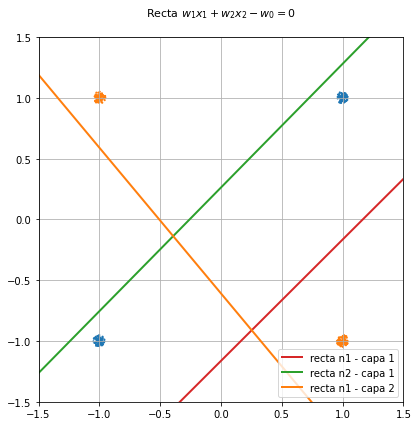

In [20]:
# pesos primer neurona
w1 = network[0].w[0]

# pesos segunda neurona
w2 = network[0].w[1]

# pesos neurona capa 2
w21 = network[1].w[0]

fig1 = plt.figure(figsize=(7, 6), tight_layout=True)
fig1.suptitle('Recta $w_1 x_1 + w_2 x_2 - w_0 = 0$',  fontsize=11)
fig1_ax = fig1.add_subplot(autoscale_on=False, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
fig1_ax.set_aspect('equal')
fig1_ax.grid()

# Patrones
x_x = X_test[:,0]
x_y = X_test[:,1]
x_color = np.where(x_x > 0, np.where(x_y > 0, 'C0', 'C1'), np.where(x_y < 0, 'C0', 'C1'))
fig1_ax.scatter(x_x, x_y, c=x_color, s=5, marker='.')

# Recta
xx = np.arange(-3, 3, 0.01)
a1 = w1[0] / w1[2]
b1 = w1[1] / w1[2]
fig1_ax.plot(xx, a1 - b1 * xx, c='C3', linewidth=2, label = 'recta n1 - capa 1')

a2 = w2[0] / w2[2]
b2 = w2[1] / w2[2]
fig1_ax.plot(xx, a2 - b2 * xx, c='C2', linewidth=2, label = 'recta n2 - capa 1')

a3 = w21[0] / w21[2]
b3 = w21[1] / w21[2]
fig1_ax.plot(xx, a3 - b3 * xx, c='C1', linewidth=2,label = 'recta n1 - capa 2')

fig1_ax.legend(loc = 4)
plt.show()


## Problema Concentlite

Para entrenar y probar el algoritmo utilice la base de datos $concentlite.csv$, que consiste en dos clases distribuidas en forma concéntrica como muestra la Figura 2. Represente gráficamente, con diferentes colores, el resultado de la clasificación realizada por el perceptrón multicapa.

### Train

In [ ]:
ds, M_tst, M_trn  =  generar_particiones('icgtp1datos\concentlite.csv', 1, 0.2)
X = ds[M_trn[0,:], :-1]
#X_a = np.array([[-1.0291,0.97256],[1.0325,-1.0188]])

# print(X)
Y_d = ds[M_trn[0,:], -1]
#Y_d = [1, 1]
# print(Y_d)
network = []
# X = np.hstack((-1, np.ones((X.shape[0],1)), X))
n_per_layer = np.array([3, 2, 1])
network = perceptron_multilayer_init(n_per_layer, X.shape[1])
#print(f'pesos capa 1{network[0].w}')
#print(f'pesos capa 2{network[1].w}')

cant_epocas = 400
nu_error = 0.01
error_epocas = []
gamma_aprend = 0.01
mse_epocas = []

for n_epoch in range(cant_epocas):
    for i, pattern in enumerate(X):
        #print('patron:', pattern)
        y = perceptron_multilayer_forward(network, pattern)
        #print(f'salida{i}={y}')
        grad = perceptron_multilayer_backward(network, y, Y_d[i])
        #print(f'gradiente = {grad}')
        network = perceptron_multilayer_update(network, y, grad, gamma_aprend)
    
    # Validación [con todos los patrones]
    errores = 0
    for n, patron in enumerate(X):
        # producto punto
        y_test = perceptron_multilayer_forward(network, patron)
        # estamos suponiendo una sola salida
        #y = -1 if (y_test[-1] < 0) else 1
        y_aux=0
        if (y_test[-1] < 0):
            y_aux=-1
        else:
            y_aux=1
        # print('y',y,'yDeseada',Y_d[n])
        errores += int(y_aux != Y_d[n])
        # print('errores', errores)}

        #cálculo del error cuadrático medio
        mse = np.sum(pow(np.subtract(y_test[-1], Y_d[n]), 2))
        
        # print(mse)
        mse_epoca = np.append(mse_epoca, mse)

    error = (errores/X.shape[0])
        # error = np.sum(((y[-1]-Y_d[i])**2))        
    error_epocas= np.append(error_epocas, [error])
    
    e_prom = np.mean(mse_epoca)
    mse_epocas = np.append(mse_epocas, e_prom)

    print(f'Epoca {n_epoch}: error = {error}')
    if (error < nu_error):
        # print(f'Época {n_epoch}')
        break
   
print(f'Epoca {n_epoch}: error = {error_epocas[-1]}')

### Test

In [46]:
X_test = ds[M_tst[0,:], :-1]
Y_d_test = ds[M_tst[0,:], -1]
errores = 0
historial_y = np.array([])

for i, pattern in enumerate(X_test):
    y_test = perceptron_multilayer_forward(network, pattern)
    historial_y = np.append(historial_y, y_test[-1])
    # estamos suponiendo una sola salida
    #y = -1 if (y_test[-1] < 0) else 1
    historial_y = np.append(historial_y, y)
    if y != Y_d_test[i]:
        errores += 1

print(f'tasa de aciertos de test {(errores / X_test.shape[0])}')
#print(historial_y)


tasa de aciertos de test 0.3253012048192771


### Plot

y_d = 1.0,  y = 0.30102355931279146
y_d = 1.0,  y = 1.0
y_d = 1.0,  y = 0.30091759395133333
y_d = -1.0,  y = 1.0
y_d = -1.0,  y = 0.30102355931279146
y_d = -1.0,  y = 1.0
y_d = 1.0,  y = 0.3011418978524516
y_d = 1.0,  y = 1.0
y_d = 1.0,  y = 0.30107379421433933
y_d = -1.0,  y = 1.0
y_d = -1.0,  y = 0.30092247071890865
y_d = -1.0,  y = 1.0
y_d = -1.0,  y = 0.3011609503848509
y_d = 1.0,  y = 1.0
y_d = 1.0,  y = 0.3011034316415768
y_d = -1.0,  y = 1.0
y_d = 1.0,  y = 0.3010582466904923
y_d = -1.0,  y = 1.0
y_d = 1.0,  y = 0.30097751374397674
y_d = 1.0,  y = 1.0
y_d = 1.0,  y = 0.30106099919768115
y_d = 1.0,  y = 1.0
y_d = -1.0,  y = 0.30103775256419696
y_d = -1.0,  y = 1.0
y_d = -1.0,  y = 0.3009577083237771
y_d = 1.0,  y = 1.0
y_d = 1.0,  y = 0.30111182034008355
y_d = 1.0,  y = 1.0
y_d = 1.0,  y = 0.3008399524202212
y_d = 1.0,  y = 1.0
y_d = 1.0,  y = 0.3011280473423352
y_d = 1.0,  y = 1.0
y_d = -1.0,  y = 0.3011034316415768
y_d = 1.0,  y = 1.0
y_d = -1.0,  y = 0.30104757758530143
y_d = 

ValueError: 'c' argument has 332 elements, which is inconsistent with 'x' and 'y' with size 166.

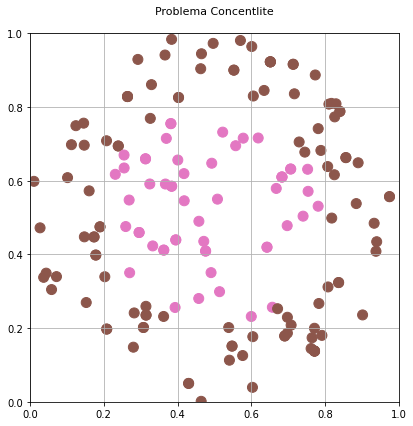

In [47]:
# Código de colores
# [C1] = clase 1 - mal identificados
# [C2] = clase 1 - bien identificados
# [C3] = clase 2 - mal identificados
# [C4] = clase 2 - bien identificados

# Pregunto por el valor de la salida, si es 1 y está dentro del vector de índices erróneos, entra en C1
# Si es 1 y no está dentro, C2
# Si es -1 y está dentro, C3
# Si es 1 y no está dentro, C4

# pesos primer neurona
for i in range(len(Y_d_test)):
    print(f'y_d = {Y_d_test[i]},  y = {historial_y[i]}')
w1 = network[0].w[0]

# pesos segunda neurona
w2 = network[0].w[1]

# pesos neurona capa 2
w3 = network[0].w[2]

fig1 = plt.figure(figsize=(7, 6), tight_layout=True)
fig1.suptitle('Problema Concentlite',  fontsize=11)
fig1_ax = fig1.add_subplot(autoscale_on=False)
fig1_ax.set_aspect('equal')
fig1_ax.grid()

# Patrones
x_x = X_test[:,0]
x_y = X_test[:,1]


# Código de colores
# [C0] = clase 1 - bien identificados
# [C1] = clase 1 - mal identificados
# [C2] = clase 2 - bien identificados
# [C3] = clase 2 - mal identificados

#x_color = []
# for i in range(len(historial_y)):
    
#     if historial_y[i] == 1 and Y_d_test[i] == 1:
#         x_color.append('C0')
#     if historial_y[i] == 1 and Y_d_test[i] != 1:
#         x_color.append('C1')
#     if historial_y[i] == -1 and Y_d_test[i] == 1:
#         x_color.append('C2')
#     if historial_y[i] == 1 and Y_d_test[i] != 1:
#         x_color.append('C3')
# print(x_color)
x_color = np.where(Y_d_test>0, 'C5', 'C6')
fig1_ax.scatter(x_x, x_y, c=x_color, s=400, marker='.')
x_color = np.where(historial_y>0, 'C3', 'C4')
fig1_ax.scatter(x_x, x_y, c=x_color, s=150, marker='.')


# Recta
xx = np.arange(-3, 3, 0.01)
a1 = w1[0] / w1[2]
b1 = w1[1] / w1[2]
fig1_ax.plot(xx, a1 - b1 * xx, c='C3', linewidth=2, label = 'recta n1 - capa 1')

a2 = w2[0] / w2[2]
b2 = w2[1] / w2[2]
fig1_ax.plot(xx, a2 - b2 * xx, c='C2', linewidth=2, label = 'recta n2 - capa 1')

a3 = w3[0] / w3[2]
b3 = w3[1] / w3[2]
fig1_ax.plot(xx, a3 - b3 * xx, c='C1', linewidth=2,label = 'recta n3 - capa 1')

fig1_ax.legend(loc = 4)


### Término de momento

Verifique experimentalmente la influencia de la incorporación del término de momento en la ecuación de adaptación de los pesos. Para esto, modifique su implementación para incluir el término de momento y compare la velocidad de convergencia del algoritmo.

Término de momento: $\alpha \Delta w_{n-1}$

Ecuación de actualización de pesos: 
$$\Delta w^{II}_{n} = \mu \delta^{II} Y^{I} + \alpha \Delta w^{II}_{n-1}$$
$$ w^{II}_{n} = w_{n-1}^{II} + \Delta w_{n}^{II}$$

### Prueba con perceptrón simple

Convierta los patrones de $concentlite.csv$ a una sola dimensión, obtenida como la distancia euclídea de cada patrón a la media total. Entrene un perceptrónn simple con estos nuevos datos unidimensionales y compare los resultados obtenidos en los puntos anteriores.

# Ejercicio 4
## Problema irisbin

En el archiv0 $irisbin.csv$ se encuentran estas mediciones (en cm) junto con
un código binario que indica la especie (clase) reconocida por el grupo de investigadores:

$[-1, -1, 1]$ = setosa,
$[-1, 1, -1]$ = versicolor,
$[1, -1, -1]$ = virginica.

Para la clasificación de una gran cantidad de estas plantas se desea crear un programa que aprenda de estos 150 patrones para luego realizar la tarea de forma automática.

Para la validación utilice los métodos $leave-k-out$ y $leave-one-out$ con un perceptrón multicapa como clasificador.
Estime:
1. Error esperado de clasificación,
2. Promedio y desviación estándar, según los dos métodos y compárelos.

### Train

In [ ]:
ds, M_tst, M_trn  =  generar_particiones('icgtp1datos\irisbin.csv', 1, 0.2)
print(ds)
X = ds[M_trn[0,:], :-3]
#X_a = np.array([[-1.0291,0.97256],[1.0325,-1.0188]])

print(X)
Y_d = ds[M_trn[0,:], -3:]
#Y_d = [1, 1]
print(Y_d)
network = []
# X = np.hstack((-1, np.ones((X.shape[0],1)), X))
n_per_layer = np.array([2, 1])
network = perceptron_multilayer_init(n_per_layer, X.shape[1])
#print(f'pesos capa 1{network[0].w}')
#print(f'pesos capa 2{network[1].w}')

cant_epocas = 300
nu_error = 0.03
error_porc_epocas = []
mse_epocas = []
gamma_aprend = 0.01

for n_epoch in range(cant_epocas):
    for i, pattern in enumerate(X):
        # print('patron:', pattern)
        y = perceptron_multilayer_forward(network, pattern)
        #print(f'salida{i}={y}')
        grad = perceptron_multilayer_backward(network, y, Y_d[i])
        #print(f'gradiente = {grad}')
        network = perceptron_multilayer_update(network, y, grad, gamma_aprend)
    
    # Validación [con todos los patrones]
    errores = 0
    mse_epoca = []
    for n, patron in enumerate(X):
        # producto punto
        y_test = perceptron_multilayer_forward(network, patron)
        # estamos suponiendo una sola salida
        # y = -1 if (y_test[-1] < 0) else 1
        # print(y_test[-1])
        # cálculo del error por tasa de aciertos
        y_aux=0
        if (y_test[-1] < 0):
            y_aux=-1
        else:
            y_aux=1
        # print('y',y,'yDeseada',Y_d[n])
        errores += int(y_aux != Y_d[n])
        # print('errores', errores)

        #cálculo del error cuadrático medio
        mse = np.sum(pow(np.subtract(y_test[-1], Y_d[n]), 2))
        
        # print(mse)
        mse_epoca = np.append(mse_epoca, mse)

    error_porc = (errores/X.shape[0]) 
    error_porc_epocas = np.append(error_porc_epocas, error_porc)

    # error_epocas= np.append(error_epocas, [error])
    # print(np.mean(error_epoca))
    # print('mse_epoca:', mse_epoca)
    e_prom = np.mean(mse_epoca)
    mse_epocas = np.append(mse_epocas, e_prom)
    
    # [Consideramos tasa de aciertos como error para corte de train]
    if (error_porc < nu_error):
        break

print(f'Epoca {n_epoch}: error = {error_porc_epocas[-1]}')


[[ 4.5  2.3  1.3 ... -1.  -1.   1. ]
 [ 5.1  3.3  1.7 ... -1.  -1.   1. ]
 [ 7.2  3.   5.8 ...  1.  -1.  -1. ]
 ...
 [ 5.5  2.3  4.  ... -1.   1.  -1. ]
 [ 5.6  2.8  4.9 ...  1.  -1.  -1. ]
 [ 6.1  2.6  5.6 ...  1.  -1.  -1. ]]
[[6.9 3.1 5.4 2.1]
 [5.6 2.8 4.9 2. ]
 [7.2 3.  5.8 1.6]
 [5.1 3.8 1.9 0.4]
 [5.2 3.4 1.4 0.2]
 [7.2 3.6 6.1 2.5]
 [7.1 3.  5.9 2.1]
 [5.6 2.8 4.9 2. ]
 [6.1 2.6 5.6 1.4]
 [5.  3.5 1.3 0.3]
 [5.2 3.4 1.4 0.2]
 [6.1 3.  4.9 1.8]
 [5.1 3.3 1.7 0.5]
 [6.1 2.6 5.6 1.4]
 [5.1 3.3 1.7 0.5]
 [5.2 3.4 1.4 0.2]
 [5.6 3.  4.5 1.5]
 [5.  3.3 1.4 0.2]
 [6.3 3.4 5.6 2.4]
 [5.4 3.  4.5 1.5]
 [6.7 3.1 4.7 1.5]
 [4.5 2.3 1.3 0.3]
 [4.6 3.4 1.4 0.3]
 [6.4 3.1 5.5 1.8]
 [5.3 3.7 1.5 0.2]
 [5.5 2.3 4.  1.3]
 [5.4 3.  4.5 1.5]
 [6.7 3.3 5.7 2.5]
 [7.2 3.  5.8 1.6]
 [4.5 2.3 1.3 0.3]
 [6.3 2.5 5.  1.9]
 [6.7 3.1 4.4 1.4]
 [4.6 3.4 1.4 0.3]
 [6.  2.2 5.  1.5]
 [6.4 2.8 5.6 2.2]
 [5.5 2.3 4.  1.3]
 [5.6 3.  4.5 1.5]
 [5.4 3.  4.5 1.5]
 [5.4 3.9 1.7 0.4]
 [5.2 3.4 1.4 0.2]
 [5.5 2.3 4.

ValueError: shapes (2,1) and (3,) not aligned: 1 (dim 1) != 3 (dim 0)

### Test

In [ ]:
X_test = ds[M_tst[0,:], :-1]
Y_d_test = ds[M_tst[0,:], -1]
errores = 0

for i, pattern in enumerate(X_test):
    y_test = perceptron_multilayer_forward(network, pattern)
    # estamos suponiendo una sola salida
    y = -1 if (y_test[-1] < 0) else 1
    errores += int(y != Y_d_test[i])

print(errores / X_test.shape[0])



0.04819277108433735


### Plot

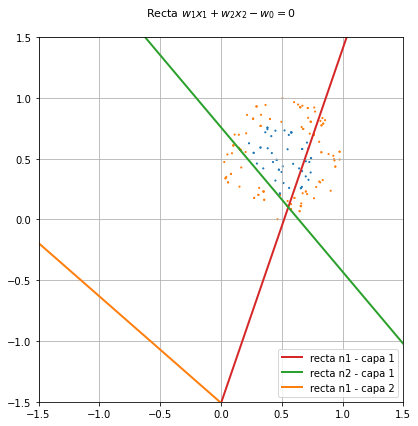

In [ ]:
# pesos primer neurona
w1 = network[0].w[0]

# pesos segunda neurona
w2 = network[0].w[1]

# pesos neurona capa 2
w21 = network[1].w[0]

fig1 = plt.figure(figsize=(7, 6), tight_layout=True)
fig1.suptitle('Recta $w_1 x_1 + w_2 x_2 - w_0 = 0$',  fontsize=11)
fig1_ax = fig1.add_subplot(autoscale_on=False, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
fig1_ax.set_aspect('equal')
fig1_ax.grid()

# Patrones
x_x = X_test[:,0]
x_y = X_test[:,1]

x_color = np.where(Y_d_test>0, 'C1', 'C0')
fig1_ax.scatter(x_x, x_y, c=x_color, s=5, marker='.')

x_color = np.where(Y_d_test>0, 'C1', 'C0')



# Recta
xx = np.arange(-3, 3, 0.01)
a1 = w1[0] / w1[2]
b1 = w1[1] / w1[2]
fig1_ax.plot(xx, a1 - b1 * xx, c='C3', linewidth=2, label = 'recta n1 - capa 1')

a2 = w2[0] / w2[2]
b2 = w2[1] / w2[2]
fig1_ax.plot(xx, a2 - b2 * xx, c='C2', linewidth=2, label = 'recta n2 - capa 1')

a3 = w21[0] / w21[2]
b3 = w21[1] / w21[2]
fig1_ax.plot(xx, a3 - b3 * xx, c='C1', linewidth=2,label = 'recta n1 - capa 2')

fig1_ax.legend(loc = 4)
